In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy import stats
from scipy.fftpack import fft, ifft
import bisect 
from scipy import signal
import pandas as pd
import seaborn as sns
from cdt.metrics import SHD
from cdt.metrics import precision_recall
import time
import random
import heapq
import lingam
import warnings

from helpers import *

warnings.filterwarnings("ignore")

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
T_str='3'
tstop = int(T_str)
numSamples=41
h_window=40
N=3
h=6

In [3]:
fn1='../data/groundtruth/onwfork3node.txt'
gt = getGroundTruth(fn1)

<Figure size 800x600 with 0 Axes>

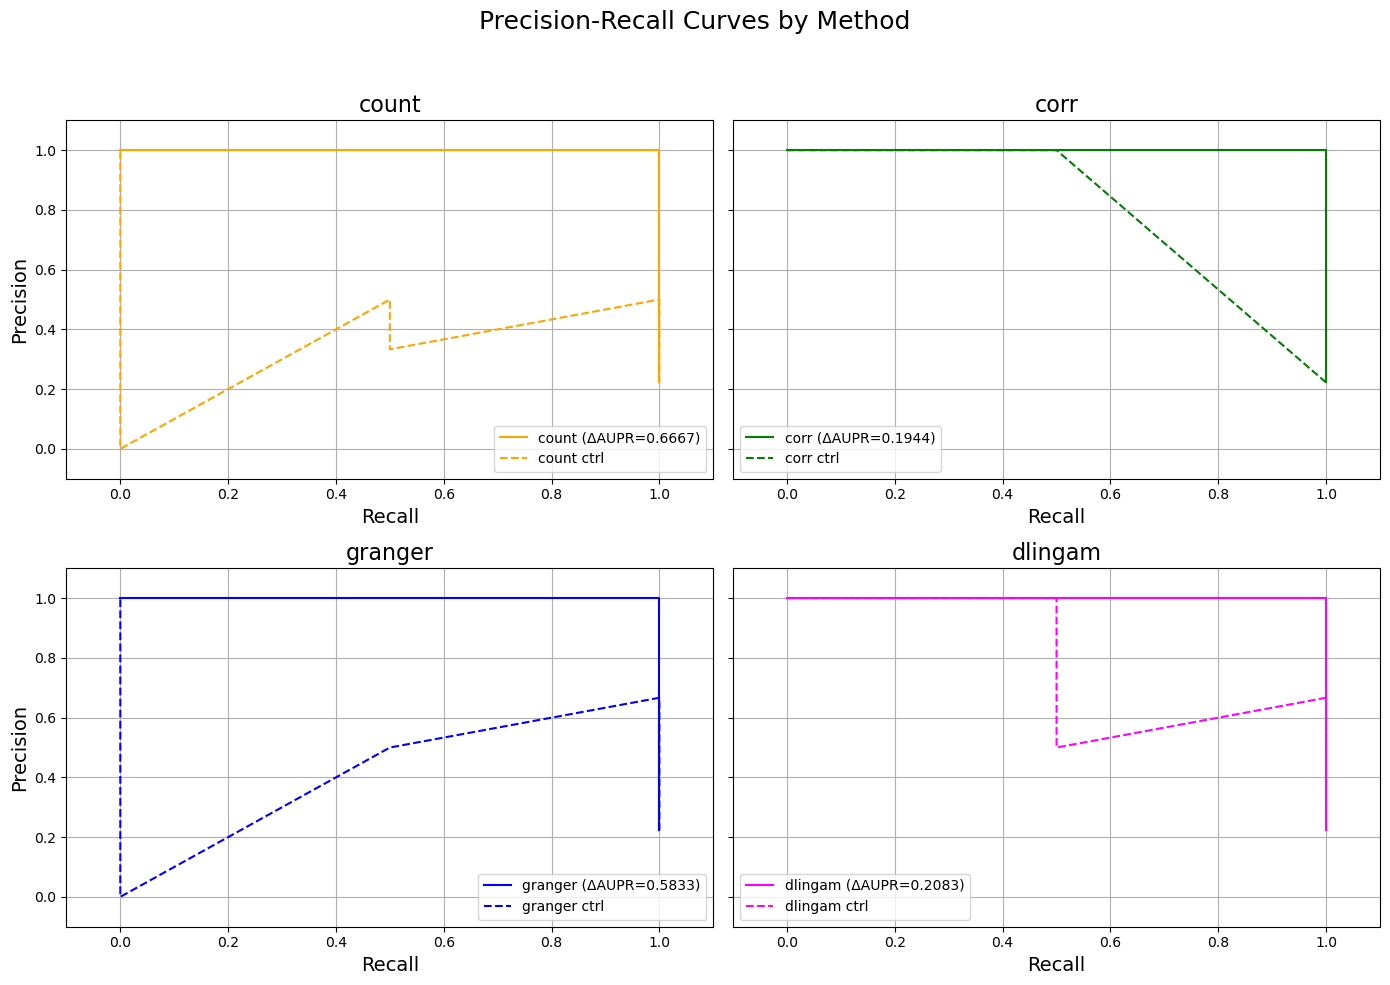

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

count_matrix = np.zeros((N,N))
corr_matrix = np.zeros((N,N))
granger_matrix = np.zeros((N,N))
dag_matrix = np.zeros((N,N))

count_matrix_ctrl = np.zeros((N,N))
corr_matrix_ctrl = np.zeros((N,N))
granger_matrix_ctrl = np.zeros((N,N))
dag_matrix_ctrl = np.zeros((N,N))

plt.figure(figsize=(8,6))

for i in range(numSamples):
    fn = f'../data/spikedatafromNEURON/outwardfork3node/outwardforkrasterplot-3node_{i}.txt'
    numSpikes, spikeTimes = getSpikesInfo(fn)
    randomized_spikes = randomISI(spikeTimes)

    # pre-process data
    binarized_mx = getBinarizedSpikeMatrix(spikeTimes, tstop, N, 1)
    binarized_mx_ctrl = getBinarizedSpikeMatrix(randomized_spikes, tstop, N, 1)
    binned_mx = getBinnedSpikeMatrix(spikeTimes, tstop, N, h_window)
    binned_mx_ctrl = getBinnedSpikeMatrix(randomized_spikes, tstop, N, h_window)

    ##### spike count #####
    count_mx = getSpikeCountMx(h, N, spikeTimes)
    count_mx_ctrl = getSpikeCountMx(h, N, randomized_spikes)
    count_matrix += count_mx
    count_matrix_ctrl += count_mx_ctrl

    ##### cross-corr #####
    C_MX = getCorrDirect(binarized_mx, N, h)
    C_MX_ctrl = getCorrDirect(binarized_mx_ctrl, N, h) 
    corr_matrix += C_MX
    corr_matrix_ctrl += C_MX_ctrl

    ##### granger #####
    output = compute_granger_matrix(binarized_mx, h)
    control = compute_granger_matrix(binarized_mx_ctrl, h)
    granger_matrix += output
    granger_matrix_ctrl += control

    ##### dlingam #####
    model1 = lingam.DirectLiNGAM()
    model1.fit(binned_mx.T)
    model2 = lingam.DirectLiNGAM()
    model2.fit(binned_mx_ctrl.T)
    dag_matrix += model1.adjacency_matrix_
    dag_matrix_ctrl += model2.adjacency_matrix_

# Average over samples
count_mx = count_matrix / numSamples
count_mx_ctrl = count_matrix_ctrl / numSamples

corr_mx = corr_matrix / numSamples
corr_mx_ctrl = corr_matrix_ctrl / numSamples

granger_mx = granger_matrix / numSamples
granger_mx_ctrl = granger_matrix_ctrl / numSamples

dag_pred = dag_matrix / numSamples
dag_pred_ctrl = dag_matrix_ctrl / numSamples

# Flatten ground truth for PR curves
y_true = gt.flatten().astype(int)

# Helper function to compute PR curve and AUPR
def get_pr_auc(y_true, score_matrix):
    y_scores = score_matrix.flatten()
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    aupr = auc(recall, precision)
    return precision, recall, aupr

# # Compute PR curves and AUPR for each method and control
# count_prec, count_rec, count_aupr = get_pr_auc(y_true, count_mx)
# count_prec_ctrl, count_rec_ctrl, count_aupr_ctrl = get_pr_auc(y_true, count_mx_ctrl)

# corr_prec, corr_rec, corr_aupr = get_pr_auc(y_true, corr_mx)
# corr_prec_ctrl, corr_rec_ctrl, corr_aupr_ctrl = get_pr_auc(y_true, corr_mx_ctrl)

# granger_prec, granger_rec, granger_aupr = get_pr_auc(y_true, granger_mx)
# granger_prec_ctrl, granger_rec_ctrl, granger_aupr_ctrl = get_pr_auc(y_true, granger_mx_ctrl)

# dag_prec, dag_rec, dag_aupr = get_pr_auc(y_true, dag_pred)
# dag_prec_ctrl, dag_rec_ctrl, dag_aupr_ctrl = get_pr_auc(y_true, dag_pred_ctrl)

# # Plot raw PR curves
# plt.plot(count_rec, count_prec, "y-", label=f"count (ΔAUPR: {count_aupr - count_aupr_ctrl:.4f})")
# plt.plot(corr_rec, corr_prec, "g-", label=f"corr (ΔAUPR: {corr_aupr - corr_aupr_ctrl:.4f})")
# plt.plot(granger_rec, granger_prec, "b-", label=f"granger (ΔAUPR: {granger_aupr - granger_aupr_ctrl:.4f})")
# plt.plot(dag_rec, dag_prec, "m-", label=f"dlingam (ΔAUPR: {dag_aupr - dag_aupr_ctrl:.4f})")

# plt.plot(count_rec_ctrl, count_prec_ctrl, "y--")
# plt.plot(corr_rec_ctrl, corr_prec_ctrl, "g--")
# plt.plot(granger_rec_ctrl, granger_prec_ctrl, "b--")
# plt.plot(dag_rec_ctrl, dag_prec_ctrl, "m--")

# plt.title("Method comparison for a 3 node chain")
# plt.xlabel("Recall", fontsize=17)
# plt.ylabel("Precision", fontsize=17)
# plt.xticks(fontsize=17)
# plt.yticks(fontsize=17)
# plt.legend()
# plt.grid(True)
# plt.show()

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
fig.suptitle("Precision-Recall Curves by Method", fontsize=18)

methods = {
    "count": (count_mx, count_mx_ctrl),
    "corr": (corr_mx, corr_mx_ctrl),
    "granger": (granger_mx, granger_mx_ctrl),
    "dlingam": (dag_pred, dag_pred_ctrl),
}

# Choose distinct colors for each method
colors = {
    "count": "orange",
    "corr": "green",
    "granger": "blue",
    "dlingam": "magenta",
}

axes = axes.flatten()  # flatten 2x2 array for easy iteration

for ax, (name, (scores, scores_ctrl)) in zip(axes, methods.items()):
    color = colors[name]
    
    prec, rec, aupr = get_pr_auc(y_true, scores)
    prec_ctrl, rec_ctrl, aupr_ctrl = get_pr_auc(y_true, scores_ctrl)
    
    ax.plot(rec, prec, '-', color=color, label=f"{name} (ΔAUPR={aupr - aupr_ctrl:.4f})")
    ax.plot(rec_ctrl, prec_ctrl, '--', color=color, label=f"{name} ctrl")
    
    ax.set_title(name, fontsize=16)
    ax.set_xlabel("Recall", fontsize=14)
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.grid(True)
    ax.legend(fontsize=10)

axes[0].set_ylabel("Precision", fontsize=14)
axes[2].set_ylabel("Precision", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


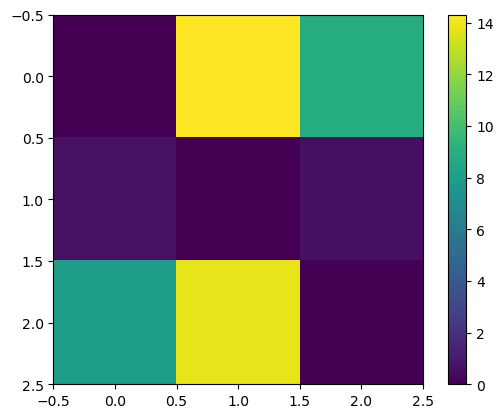

In [5]:
plt.imshow(count_mx)
plt.colorbar()

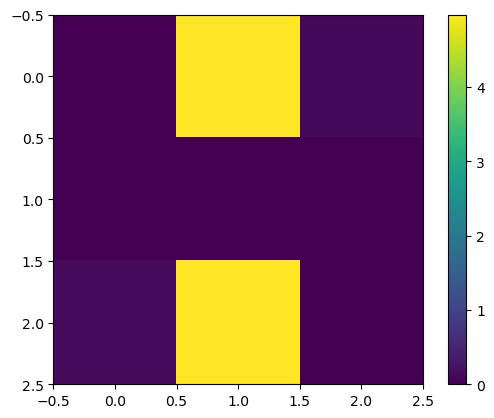

In [6]:
plt.imshow(corr_mx)
plt.colorbar()

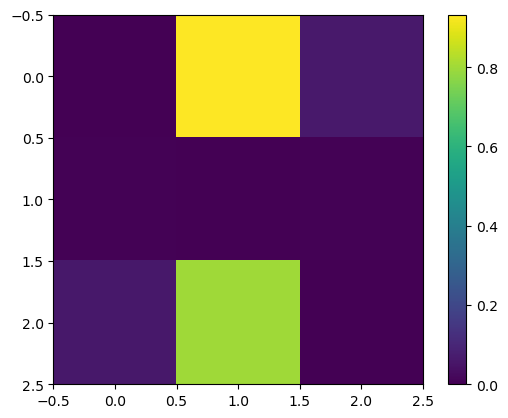

In [7]:
plt.imshow(granger_mx)
plt.colorbar()

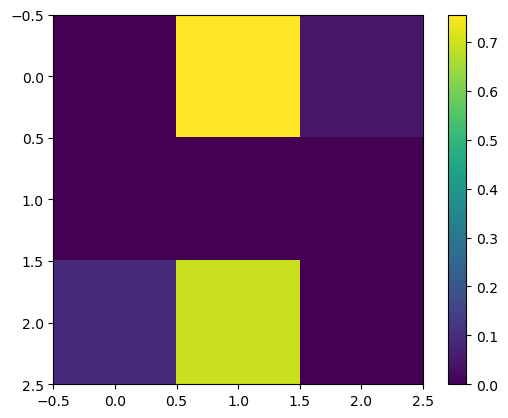

In [8]:
plt.imshow(dag_pred)
plt.colorbar()